In [1]:
import os, sys
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
#print(cluster.job_script())
w = cluster.scale(30)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.39.89:42093 Dashboard: http://10.135.39.89:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
# compute rotary spectra


In [9]:
grd = load_grdnc().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mask     (face, j, i) bool dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>


In [11]:
# spatial strides
dij=4

for face in range(13):
    
    Efile = work_data_dir+'spectra/%s_f%02d.zarr'%('SSUV',face)
    
    if not os.path.isdir(Efile):
    
        # load data
        dsu = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSU',face))
        dsv = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSV',face))
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))
        #ds['SSU'] = ds['SSU'].where(abs(ds['SSU'])<10) # tmp: SSU.0000659952.shrunk is corrupted
        ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)    

        # spatial subsetting
        ds = ds.isel(i=slice(0,None,dij), j=slice(0,None,dij))

        # should show the size of the dataset to know if we can load it in memory
        print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency
        f, E = get_E(ds['SSUV'].isel(i=2,j=2))
        #
        E = get_E(ds['SSUV'], f=f)

        # store
        E = E.to_dataset()
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready done'%face)
                

--- face 0 allready done
--- face 1 allready done
--- face 2 allready done
--- face 3 allready done
--- face 4 allready done
--- face 5 allready done


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


dataset size: 161.3 GB
CPU times: user 15min 37s, sys: 51 s, total: 16min 28s
Wall time: 16min 11s
--- face 6 done


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


dataset size: 161.3 GB
CPU times: user 23min 49s, sys: 1min 34s, total: 25min 24s
Wall time: 26min 34s
--- face 7 done


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


dataset size: 161.3 GB
CPU times: user 17min 39s, sys: 55.5 s, total: 18min 35s
Wall time: 18min 8s
--- face 8 done


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


dataset size: 161.3 GB
CPU times: user 14min 21s, sys: 38.2 s, total: 14min 59s
Wall time: 14min 41s
--- face 9 done


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


dataset size: 161.3 GB
CPU times: user 23min 24s, sys: 1min 20s, total: 24min 45s
Wall time: 26min 37s
--- face 10 done


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


dataset size: 161.3 GB
CPU times: user 16min 45s, sys: 50 s, total: 17min 35s
Wall time: 17min 13s
--- face 11 done


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


dataset size: 161.3 GB
CPU times: user 14min 24s, sys: 38.2 s, total: 15min 3s
Wall time: 14min 45s
--- face 12 done


In [ ]:
cluster.close()

### Concatenate all faces

In [10]:
v='SSUV'
E = xr.concat([xr.open_zarr(work_data_dir+'spectra/%s_f%02d.zarr'%(v,face)) 
               for face in range(13)], dim='face', compat='identical')
#print(E)
E = E.chunk({'i': 24, 'j':12})
print(E)
%time E.to_zarr(work_data_dir+'spectra/%s.zarr'%(v), mode='w')

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1920, i: 1080, j: 1080)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    Depth      (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
    XC         (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
    YC         (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    mask       (face, j, i) bool dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<shape=(13, 1080, 1080, 1920), chunksize=(1, 12, 24, 1920)>


---
# inspect result

In [5]:
face=1
v = 'SSUV'
E = xr.open_zarr(work_data_dir+'spectra/%s_f%02d.zarr'%(v,face))[v].fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSUV' (j: 1080, i: 1080, freq_time: 1920)>
dask.array<shape=(1080, 1080, 1920), dtype=float64, chunksize=(12, 24, 1920)>
Coordinates:
    Depth      (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    XC         (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    YC         (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    face       int64 ...
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (j, i) bool dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>

 data size: 17.9 GB


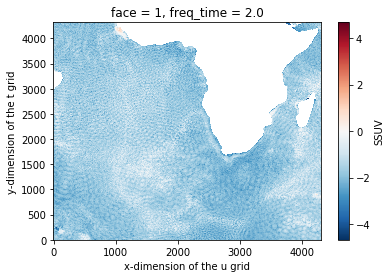

In [6]:
np.log10(E.sel(freq_time=2., method='nearest')).plot()

In [7]:
df = E.freq_time[1]-E.freq_time[0]
E2 = E.where(abs(abs(E.freq_time)-2.)<.2, other=0.).sum(dim='freq_time')*df
E2 = E2.where(E2>0)
print(E2)

<xarray.DataArray (j: 1080, i: 1080)>
dask.array<shape=(1080, 1080), dtype=float64, chunksize=(12, 24)>
Coordinates:
    Depth    (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    XC       (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    YC       (j, i) float32 dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>
    face     int64 1
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    mask     (j, i) bool dask.array<shape=(1080, 1080), chunksize=(1080, 1080)>


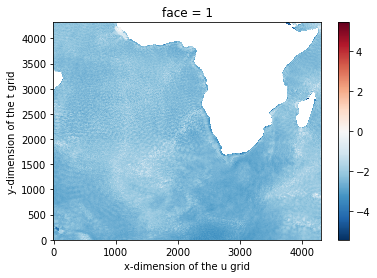

In [8]:
np.log10(E2).plot()

with concatenated faces

In [12]:
v = 'SSUV'
E = xr.open_zarr(work_data_dir+'spectra/%s.zarr'%(v))[v].fillna(0.)
#E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSUV' (face: 13, j: 1080, i: 1080, freq_time: 1920)>
dask.array<shape=(13, 1080, 1080, 1920), dtype=float64, chunksize=(1, 12, 24, 1920)>
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
    XC         (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
    YC         (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.96 11.98 11.99
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) int8 dask.array<shape=(13, 1080, 1080), chunksize=(1, 12, 24)>

 data size: 232.9 GB


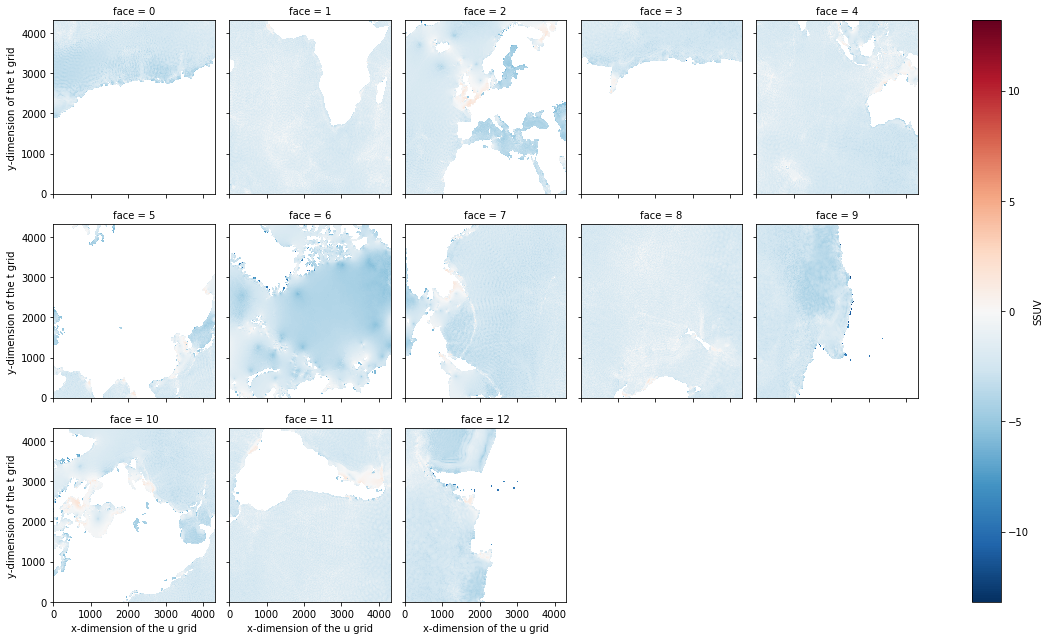

In [14]:
(np.log10(E.sel(freq_time=2., method='nearest'))
 .plot(col='face', col_wrap=5)) #, vmin=-1., vmax=1.)

---
# debug multitapper

In [3]:
face=1
    
# load data
dsu = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSU',face))
dsv = xr.open_zarr(work_data_dir+'rechunked/%s_f%02d.zarr'%('SSV',face))
ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
              compat='equals').assign_coords(**grd_rspec.sel(face=face))
#ds['SSU'] = ds['SSU'].where(abs(ds['SSU'])<10) # tmp: SSU.0000659952.shrunk is corrupted
ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)    

# spatial subsetting
ds = ds.isel(i=slice(0,10), j=slice(0,10))

print(ds)
# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

# spectral computation
# need to run once to get frequency
#f, E = get_E(ds['SSUV'].isel(i=2,j=2))
#
#E = get_E(ds['SSUV'], f=f)


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


<xarray.Dataset>
Dimensions:  (i: 10, j: 10, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(8640,)>
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9
    iters    (time) int64 dask.array<shape=(8640,), chunksize=(240,)>
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.68e+07 3.68e+07
    Depth    (j, i) float32 dask.array<shape=(10, 10), chunksize=(10, 10)>
    XC       (j, i) float32 dask.array<shape=(10, 10), chunksize=(10, 10)>
    YC       (j, i) float32 dask.array<shape=(10, 10), chunksize=(10, 10)>
    mask     (j, i) bool dask.array<shape=(10, 10), chunksize=(10, 10)>
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(8640, 10, 10), chunksize=(240, 10, 10)>
    SSV      (time, j, i) float32 dask.array<shape=(8640, 10, 10), chunksize=(240, 10, 10)>
    SSUV     (time, j, i) complex64 dask.array<shape=(8640, 10, 10), chunksize=(240, 10, 10)>
dat

In [4]:
from spectrum import dpss, pmtm

In [10]:
uv = ds.SSUV.isel(time=slice(0,240),i=0,j=0).values
print(uv.shape)
E = pmtm(uv, NW=2.5, k=4, show=False)
print(E[0].shape)
print(E[1].shape)
print(E[2].shape)

(240,)
(4, 256)
(256, 4)
(4,)


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/spectrum/mtm.py:529: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/spectrum/mtm.py:530: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or 

In [ ]:
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E
    
E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)


In [ ]:


def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 80*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [ ]:
cluster.close()